In [96]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense,Conv1D,MaxPooling1D,UpSampling1D,Flatten,add
from tensorflow.keras.callbacks import ModelCheckpoint

from AD_tools import * # specifically need training()

In [97]:
plt.rcParams.update({
    'figure.figsize': (6,5),
    'font.size': 16,
    })

In [98]:
name = "single_cut_eigenvals"

In [99]:
data = np.loadtxt("data/dataD6RDMEWcut03.txt")
data.shape

(101, 19)

In [100]:
xx, yy = data[:,0], data[:,1]

In [101]:
sorter = np.argsort(xx)
xx, yy = xx[sorter], yy[sorter]

In [102]:
x_data = data[:,3:][sorter]

In [103]:
x_data.shape

(101, 16)

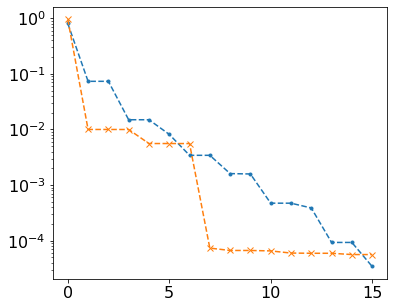

In [104]:
plt.plot(x_data[0],".--")
plt.plot(x_data[-1],"x--")
plt.yscale("log")

In [114]:
x_test = x_data.copy()

# Geometric analysis

In [115]:
def norm(x):
    return np.sqrt(np.inner(x,x))

In [116]:
def entrop(x):
    return -1*np.sum(np.log(x)*x)

In [117]:
x_normed = np.zeros(x_test.shape)
for j,x in enumerate(x_test):
    x_normed[j] = x/np.sqrt(np.inner(x,x))

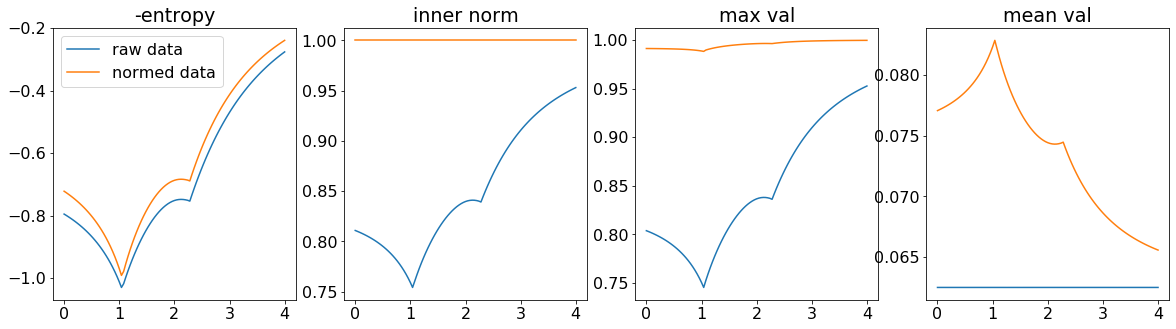

In [124]:
fig, axs = plt.subplots(ncols=4,figsize=(20,5))
ax = axs[0]
ax.plot(xx,[-entrop(x) for x in x_test], label="raw data")
ax.plot(xx,[-entrop(x) for x in x_normed], label = "normed data")
ax.set_title("-entropy")
ax.legend()

ax = axs[1]
ax.plot(xx,[norm(x) for x in x_test])
ax.plot(xx,[norm(x) for x in x_normed])
ax.set_title("inner norm")

ax = axs[2]
ax.plot(xx,[np.max(x) for x in x_test])
ax.plot(xx,[np.max(x) for x in x_normed])
ax.set_title("max val")

ax = axs[3]
ax.plot(xx,[np.mean(x) for x in x_test])
ax.plot(xx,[np.mean(x) for x in x_normed])
ax.set_title("mean val")

plt.savefig("plots/" + name + "_data-bias.png")

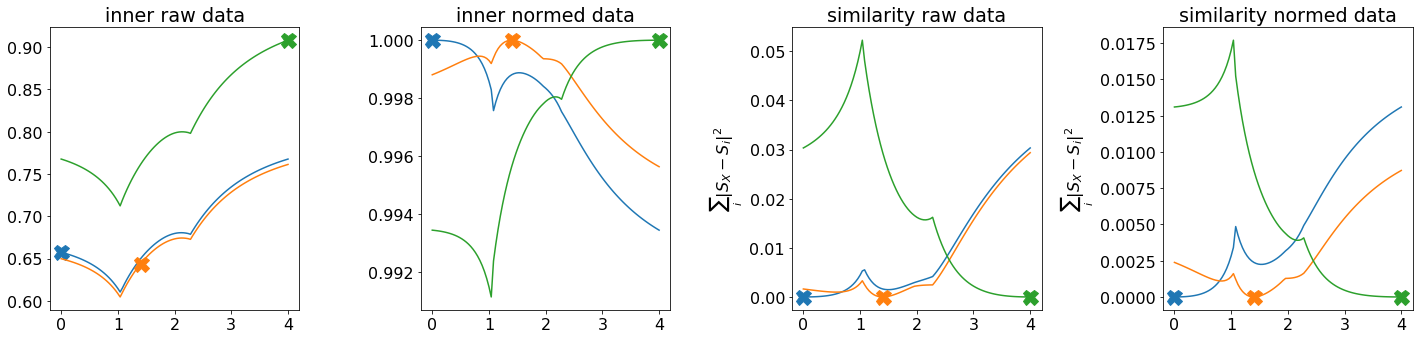

In [125]:
fig, axs = plt.subplots(ncols=4, figsize=(20,5))
picks = [0,35,-1]
color = ["tab:blue", "tab:orange", "tab:green"]
ax = axs[0]
for i, pick in enumerate(picks):    
    overlaps0 = [np.inner(x_test[pick], x_test[j]) for j,_ in enumerate(x_normed)]
    ax.plot(xx, overlaps0,"-", color=color[i])
    ax.plot(xx[pick], overlaps0[pick],"X",markersize=15, color=color[i])
ax.set_title("inner raw data")
    
ax = axs[1]
for i, pick in enumerate(picks):    
    overlaps0 = [np.inner(x_normed[pick], x_normed[j]) for j,_ in enumerate(x_normed)]
    ax.plot(xx, overlaps0,"-", color=color[i])
    ax.plot(xx[pick], overlaps0[pick],"X",markersize=15, color=color[i])
ax.set_title("inner normed data")

ax = axs[2]
for i, pick in enumerate(picks):    
    overlaps0 = [np.sum(np.abs(x_test[pick] - x_test[j])**2) for j,_ in enumerate(x_data)]
    ax.plot(xx, overlaps0,"-", color=color[i])
    ax.plot(xx[pick], overlaps0[pick],"X",markersize=15, color=color[i])
ax.set_title("similarity raw data")
ax.set_ylabel("$\\sum_i |S_X - S_i|^2$")

ax = axs[3]
for i, pick in enumerate(picks):    
    overlaps0 = [np.sum(np.abs(x_normed[pick] - x_normed[j])**2) for j,_ in enumerate(x_data)]
    ax.plot(xx, overlaps0,"-", color=color[i])
    ax.plot(xx[pick], overlaps0[pick],"X",markersize=15, color=color[i])
ax.set_title("similarity normed data")
ax.set_ylabel("$\\sum_i |S_X - S_i|^2$")

plt.tight_layout()
plt.savefig("plots/" + name + "_geometric_analysis.png")

# Anomaly Detection

In [126]:
shape_ = x_test.shape[1:]

In [127]:
def picker(fillings, fmin, fmax):
    fillings = np.array(fillings)
    pickle = np.where((fillings>= fmin) & (fillings <= fmax))
    return pickle, fillings[pickle]

In [128]:
rate=0.2 # Dropout percentage
bottleneck = 50 # latent space dimension, does not make great differences
fully = True

In [129]:
def cnnx(loss,optimizer,activation0,activation,x_shape,dim1=(16,(3,)),dim2=(16,(3,)), fully=False):
    """ 
    Pretty Standard Convolutional Autoencoder with a fully-connected latent space
    activation0: Activations "inside" the CAE
    activation: Last activation (important depending on the range of the pixel values)
    """
    in_dim = x_shape
    input_img = Input(shape=in_dim)
   
    #x1 = Conv1D(*dim1, activation=activation0, padding='same')(input_img)
    #x2 = MaxPooling1D((2,), padding='same')(x1)
    #x2 = Conv1D(*dim2, activation=activation0, padding='same')(x2)
    #x3 = MaxPooling1D((2,), padding='same')(x2)
    #encoded = Conv1D(*dim2, activation=activation0, padding='same')(x2)
    
    encoded = Flatten()(input_img)
    encoded = Dense(units=100,activation=activation0)(encoded)
    encoded = tf.keras.layers.Dropout(rate)(encoded)
    encoded = Dense(units=25,activation=activation0)(encoded)
    
    y = Dense(units=100,activation=activation0)(encoded)
    y = tf.keras.layers.Dropout(rate)(y)

    #y=UpSampling1D(2)(encoded)
    #y=Conv1D(*dim1, activation=activation0, padding='same')(y)
    #y=UpSampling1D(2)(y)
    decoded = Dense(np.prod(in_dim), activation=activation)(y)
    decoded = tf.keras.layers.Reshape(in_dim)(decoded)
    

    cnn = Model(input_img, decoded)
    cnn.compile(loss=loss,optimizer=optimizer)
    return cnn

In [130]:
# Show Network architecture
cnn = cnnx("mse","adam","linear","relu",x_shape=(10,4))
cnn.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 10, 4)]           0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 40)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 100)               4100      
_________________________________________________________________
dropout_36 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 25)                2525      
_________________________________________________________________
dense_74 (Dense)             (None, 100)               2600      
_________________________________________________________________
dropout_37 (Dropout)         (None, 100)               0  

In [131]:
def create_out(cnn1):
    """
    Creates (dim_freq, dim_phase) matrix of the output loss and the standard deviation
    """
    y_test = cnn1.predict(x_test)
    return 100*eval_loss(x_test,y_test,norm=norm2)/eval_loss(x_test,0*x_test,norm=norm2)

In [132]:
train1s = [(0,0.3),(3.3,np.max(xx)),(1.4,1.8)]

# Training

### raw data
(kind of already normalized but first value much larger than the rest)

In [133]:
cnns = [None]*len(train1s)
outs = [None]*len(train1s)

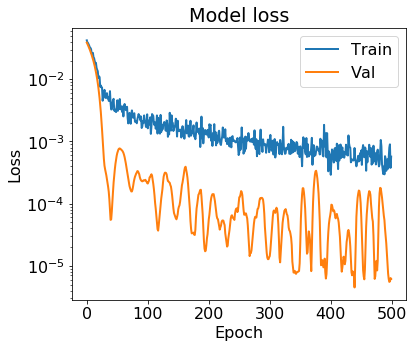

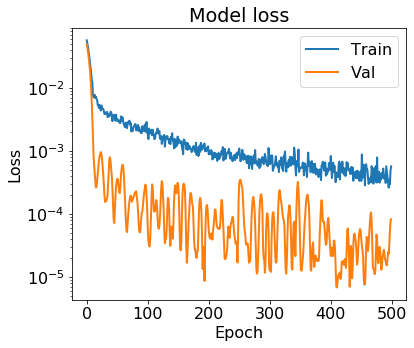

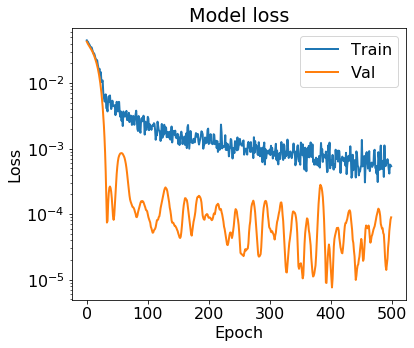

In [134]:
for i,train1 in enumerate(train1s):
    pickle, xx_train = picker(xx,*train1)
    x_train = x_test[pickle]
    cnns[i] = training(x_train = x_train,choose_cnn = cnnx, name = name, provide_cnn = False,
                 load_prev= False, num_epochs = 500,  verbose_val=0, batch_size = 16, shuffle=True, early=False,
                 loss="mse", activation0 = 'relu', activation = 'linear', optimizer = "adam",
                 dim1=(16,(3,)), dim2=(16,(3,)), x_shape = shape_)
    outs[i] = create_out(cnns[i])

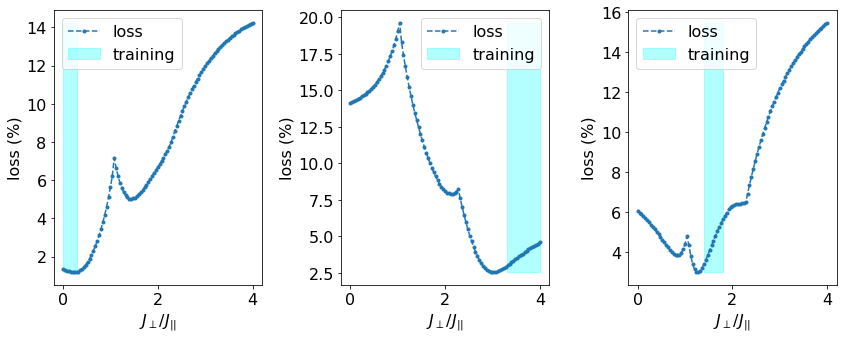

In [135]:
fig, axs = plt.subplots(ncols=3,figsize=(12,5))
for i,train1 in enumerate(train1s):
    ax = axs[i]
    out = outs[i]
    ax.plot(xx,out,".--",label="loss")
    ax.set_ylabel("loss (%)")
    ax.set_xlabel("$J_\perp/J_{{||}}$")
    ax.fill_between(*[train1],out.min(),out.max(),alpha=0.3,color="cyan", label="training")
    ax.legend()
    plt.tight_layout()
    
plt.tight_layout()
plt.savefig("plots/" + name + ".png")

In [136]:
np.savez("data_results" + name + "_data", outs = outs, xx = xx, train1s = train1s)

### normed data
(kind of already normalized but first value much larger than the rest)

In [137]:
x_test = x_normed.copy()

In [138]:
cnns = [None]*len(train1s)
outs = [None]*len(train1s)

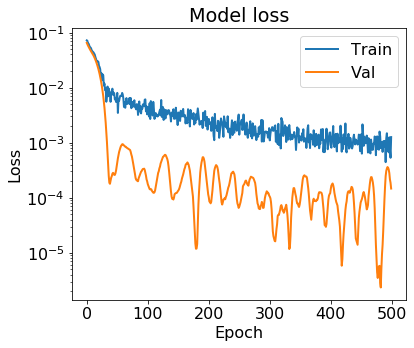

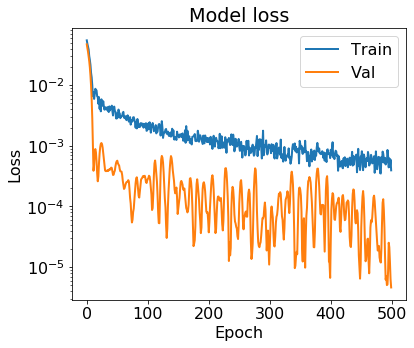

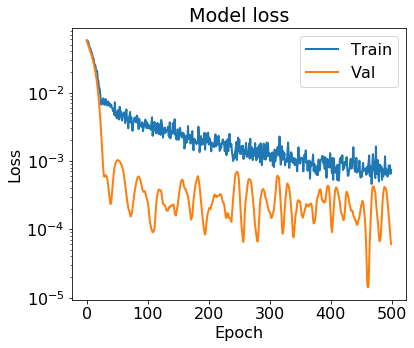

In [139]:
for i,train1 in enumerate(train1s):
    pickle, xx_train = picker(xx,*train1)
    x_train = x_test[pickle]
    cnns[i] = training(x_train = x_train,choose_cnn = cnnx, name = name, provide_cnn = False,
                 load_prev= False, num_epochs = 500,  verbose_val=0, batch_size = 16, shuffle=True, early=False,
                 loss="mse", activation0 = 'relu', activation = 'linear', optimizer = "adam",
                 dim1=(16,(3,)), dim2=(16,(3,)), x_shape = shape_)
    outs[i] = create_out(cnns[i])

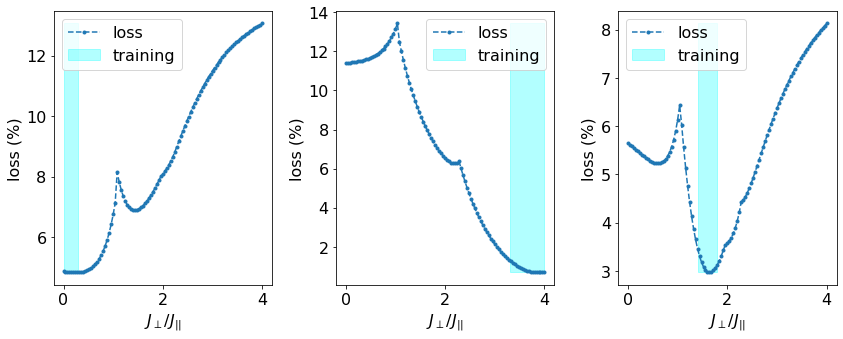

In [140]:
fig, axs = plt.subplots(ncols=3,figsize=(12,5))
for i,train1 in enumerate(train1s):
    ax = axs[i]
    out = outs[i]
    ax.plot(xx,out,".--",label="loss")
    ax.set_ylabel("loss (%)")
    ax.set_xlabel("$J_\perp/J_{{||}}$")
    ax.fill_between(*[train1],out.min(),out.max(),alpha=0.3,color="cyan", label="training")
    ax.legend()
    plt.tight_layout()
    
plt.tight_layout()
plt.savefig("plots/" + name + "_normed.png")

In [141]:
np.savez("data_results" + name + "_data_normed", outs = outs, xx = xx, train1s = train1s)

### rescale values
to log scale

In [142]:
x_test = np.log(x_data)

In [143]:
cnns = [None]*len(train1s)
outs = [None]*len(train1s)

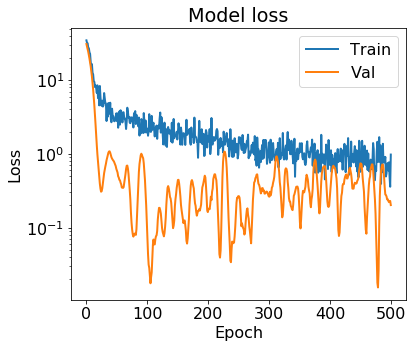

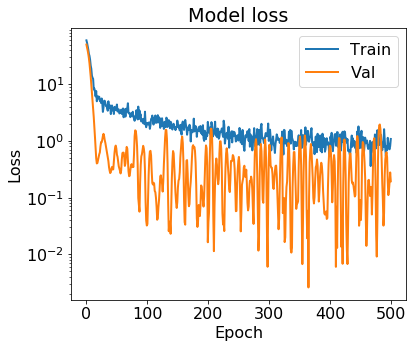

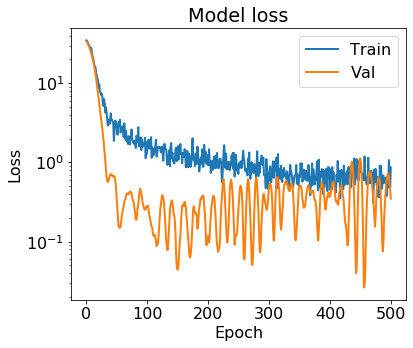

In [144]:
for i,train1 in enumerate(train1s):
    pickle, xx_train = picker(xx,*train1)
    x_train = x_test[pickle]
    cnns[i] = training(x_train = x_train,choose_cnn = cnnx, name = name, provide_cnn = False,
                 load_prev= False, num_epochs = 500,  verbose_val=0, batch_size = 16, shuffle=True, early=False,
                 loss="mse", activation0 = 'relu', activation = 'linear', optimizer = "adam",
                 dim1=(16,(3,)), dim2=(16,(3,)), x_shape = shape_)
    outs[i] = create_out(cnns[i])

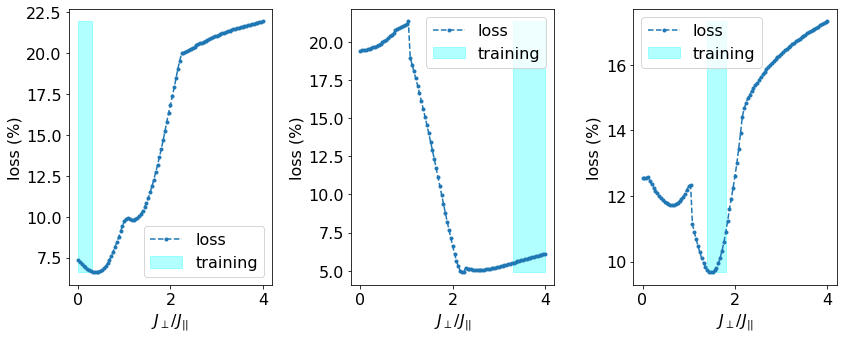

In [145]:
fig, axs = plt.subplots(ncols=3,figsize=(12,5))
for i,train1 in enumerate(train1s):
    ax = axs[i]
    out = outs[i]
    ax.plot(xx,out,".--",label="loss")
    ax.set_ylabel("loss (%)")
    ax.set_xlabel("$J_\perp/J_{{||}}$")
    ax.fill_between(*[train1],out.min(),out.max(),alpha=0.3,color="cyan", label="training")
    ax.legend()
    plt.tight_layout()
    
plt.tight_layout()
plt.savefig("plots/" + name + "_logscale.png")

In [146]:
np.savez("data_results" + name + "_data_logscale", outs = outs, xx = xx, train1s = train1s)